<h1><b>Fack News Classification</b></h1>
<hr>
<h3>Develop a machine learning program to identify when an article might be fake news. Run by the UTK Machine Learning Club.</h3>

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from wordcloud import WordCloud
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
#read the data
train_data=pd.read_csv('/content/train.csv')
test_data=pd.read_csv('/content/test.csv')
# sub_data=pd.read_csv('/content/submit.csv')

In [6]:
train_data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [7]:
train_data.shape

(20800, 5)

In [11]:
#check for null values
print(train_data.isnull().sum())
print(test_data.isnull().sum())

id           0
title      558
author    1957
text        39
label        0
dtype: int64
id          0
title     122
author    503
text        7
dtype: int64


**here we can see we have some null values so we need to hendle this**

In [12]:
#we fill this null values by blank string
train=train_data.fillna('')
test=test_data.fillna('')

In [13]:
print(train.isnull().sum())
print(test.isnull().sum())

id        0
title     0
author    0
text      0
label     0
dtype: int64
id        0
title     0
author    0
text      0
dtype: int64


<h2><b>Exploratory Data Analysis on the data</b></h2>

In [14]:
train.columns

Index(['id', 'title', 'author', 'text', 'label'], dtype='object')

In [15]:
train['label'].value_counts()

1    10413
0    10387
Name: label, dtype: int64

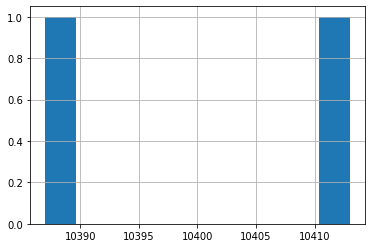

In [16]:
train['label'].value_counts().hist()

**here we can we that both values are more or less same distributed and the data set is  balanced.**
<br>
1>> 10413
<br>
0>> 10387


In [49]:
def printCloud(columns,label):
    real = train[train['label']==label]
    text = ''
    for news in real[columns].values:
        text += f" {news}"  # f will help to retain the text as a string
    wordcloud = WordCloud(width = 800,height = 800, background_color = 'black',
                        stopwords = set(nltk.corpus.stopwords.words("english")),min_font_size = 10).generate(text)
    fig = plt.figure(
        figsize = (5, 7),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    del text

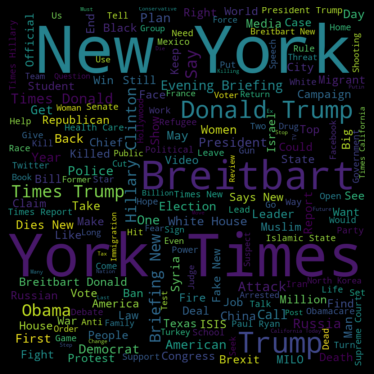

In [50]:
#first we create a word cloud for real news on title columns
printCloud('title',0)

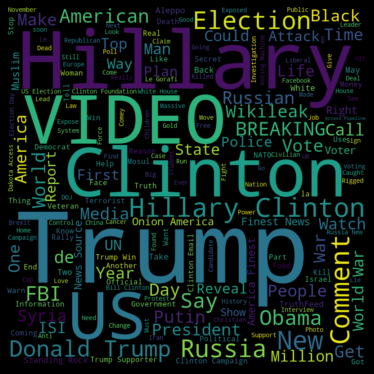

In [51]:
#first we create a word cloud for fack news on title columns
printCloud('title',1)

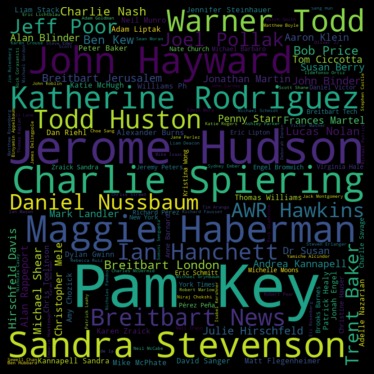

In [52]:
#first we create a word cloud for real news on author columns
printCloud('author',0)

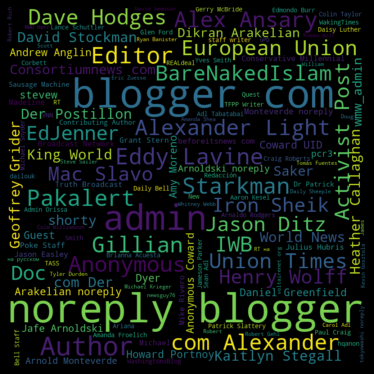

In [53]:
#first we create a word cloud for fack news on author columns
printCloud('author',1)

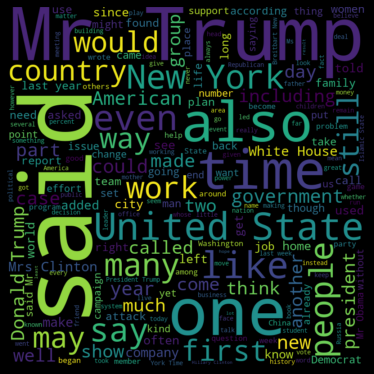

In [54]:
#first we create a word cloud for real news on text columns
printCloud('text',0)

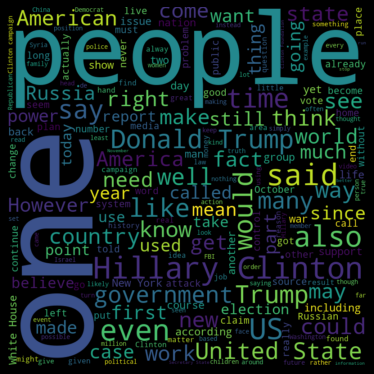

In [55]:
#first we create a word cloud for real news on text columns
printCloud('text',1)

<h2><b>Create New Feature </h>
<hr>

In [56]:
# Creating a new independent variable  : concatenating author and title column
# This new independent variable (creating using author and title column) would be perform better in classifying the real and fake news instead of taking an individual variable
# Will use this new independent variable in building the model

train['ti_auth'] = train['title']+' '+ train['author']
test['ti_auth']= test['title']+' '+test['author']

<h2><b>Data preprocessing</b></h2>
<hr>
Steps as below :

1.Removing special characters and numbers

2.Converting into lowercase to develop a consistent data

3.Tokenize the text, ignoring stopwords and performing stemming on the words

In [26]:
train_x=train['ti_auth']
label_=train['label']

In [27]:
from tqdm import tqdm

In [28]:
def dataPreprocessing(data):
    ps = PorterStemmer()
    corpus_train=[]
    for i in tqdm(range(len(data))):
        input = re.sub('[^a-zA-Z]',' ',data[i]) # except a-z and A-Z, substitute all other characters with ' '
        input = input.lower() # Lower case 
        input  = input.split() # tokenize the text
        input = [ps.stem(word) for word in input if word not in stopwords.words('english')] # ignoring stopwords and stemming rest of the words
        text = ' '.join(input)  # concatenating all words into a single text (list is created)#
        corpus_train.append(text) # appending text into a single corpus #
    return corpus_train    

In [29]:
# Training data
pre_train_data=dataPreprocessing(train_x)

100%|██████████| 20800/20800 [00:45<00:00, 461.83it/s]


In [30]:
pre_test_data=(test['ti_auth'])

<h1><b>Model Building the word embedding layer with help of keras embedding and LSTM</h1>
<hr>
* Converting this text into One hot representation <br>
* Provide an index for each and every word in the text w.r.t the voc_size




In [31]:
voc_size =5000
onehot_rep_train = [one_hot(words,voc_size)for words in pre_train_data]
onehot_rep_test = [one_hot(words,voc_size)for words in pre_test_data]

In [32]:
# Train dataset #
# Find out the maximum length of the sentence in the corpus so that we will pad all sentences to that length
c=[]
for i in range(len(train_x)):
    m=len(train_x[i].split())
    c.append(m)
print('Maximum length of a sentence is : ',max(c))
print('Average length of a sentence is : ',sum(c)/len(c))

# In train dataset, max length is 74

Maximum length of a sentence is :  74
Average length of a sentence is :  14.246057692307692


In [33]:
# Test dataset #
# Find out the maximum length of the sentence in the corpus so that we will pad all sentences to that length

c=[]
for i in range(len(test)):
    m=len(test['ti_auth'][i].split())
    c.append(m)

print('Maximum length of a sentence is : ',max(c))
print('Average length of a sentence is : ',sum(c)/len(c))

# In train dataset, max length is 65

# So we will sentence length is 74 for train and test as it is maxium of the two

Maximum length of a sentence is :  65
Average length of a sentence is :  14.167692307692308


In [34]:
# Pad_sequences in order to make all sentences of equal lenghts of 74

embedded_docs_train = pad_sequences(onehot_rep_train,padding='pre',maxlen=74)
embedded_docs_test = pad_sequences(onehot_rep_test,padding='pre',maxlen=74)

In [35]:
# Building an LSTM Model with an embedding layer #
model = Sequential()
model.add(Embedding(voc_size,40,input_length=74))  # 40 : dimension of each vector, input_length : sentence length
model.add(Dropout(0.3))
model.add(LSTM(100))  # 100 memory cells / Neurons 
model.add(Dropout(0.3))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))  # sigmoid will help in classifying news as fake or real
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 74, 40)            200000    
_________________________________________________________________
dropout (Dropout)            (None, 74, 40)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                6464      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [36]:
#Converting into numpy array
train_final = np.array(embedded_docs_train)
y_final = np.array(label_)
test_final = np.array(embedded_docs_test)
print(train_final.shape,y_final.shape,test_final.shape)

(20800, 74) (20800,) (5200, 74)


In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_final, y_final, test_size=0.33, random_state=42)

In [38]:
#training model
history=model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=100)
# model.fit(train_final,y_final,epochs=5,batch_size=100)

Epoch 1/10
140/140 [==============================] - 29s 189ms/step - loss: 0.4475 - accuracy: 0.8005 - val_loss: 0.0472 - val_accuracy: 0.9825
Epoch 2/10
140/140 [==============================] - 24s 172ms/step - loss: 0.0332 - accuracy: 0.9893 - val_loss: 0.0362 - val_accuracy: 0.9873
Epoch 3/10
140/140 [==============================] - 23s 165ms/step - loss: 0.0133 - accuracy: 0.9966 - val_loss: 0.0348 - val_accuracy: 0.9886
Epoch 4/10
140/140 [==============================] - 23s 167ms/step - loss: 0.0056 - accuracy: 0.9986 - val_loss: 0.0389 - val_accuracy: 0.9889
Epoch 5/10
140/140 [==============================] - 23s 166ms/step - loss: 0.0030 - accuracy: 0.9992 - val_loss: 0.0445 - val_accuracy: 0.9879
Epoch 6/10
140/140 [==============================] - 23s 167ms/step - loss: 0.0028 - accuracy: 0.9994 - val_loss: 0.0459 - val_accuracy: 0.9892
Epoch 7/10
140/140 [==============================] - 23s 165ms/step - loss: 0.0021 - accuracy: 0.9994 - val_loss: 0.0495 - val_ac

<h1><b>Reports<b></h1>
<hr>

In [39]:
#create a function for auc and roc curve 
#it give all the matrix and classification_report
def report(y_test,y_pred):
    # null_accuracy = y_test.value_counts()[0]/len(y_test)
    # print(f"Null Accuracy: {null_accuracy*100:.4f}%")
    print("Confusion Matrix")
    matrix = confusion_matrix(y_test,y_pred)
    print(matrix)
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    TN = matrix[0,0]
    FP = matrix[0,1]
    FN = matrix[1,0]
    TP = matrix[1,1]
    accuracy_score=(TN+TP) / float(TP+TN+FP+FN)
    recall_score = (TP)/ float(TP+FN)
    specificity = TN / float(TN+FP)
    FPR = FP / float(FP+TN)
    precision_score = TP / float(TP+FP)
    print(f"Accuracy Score: {accuracy_score*100:.4f}%")
    print(f"Recall Score: {recall_score*100:.4f}%")
    print(f"Specificity Score: {specificity*100:.4f}%")
    print(f"False Positive Rate: {FPR*100:.4f}%")
    print(f"Precision Score: {precision_score*100:.4f}%")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("Classification Report")
    print(classification_report(y_test,y_pred))

In [40]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

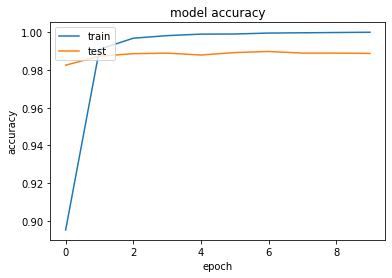

In [41]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

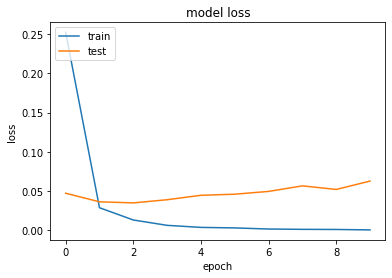

In [42]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [43]:
y_pred = model.predict_classes(X_test)
from sklearn.metrics import accuracy_score
report(y_test,y_pred)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Confusion Matrix
[[3416   33]
 [  44 3371]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy Score: 98.8782%
Recall Score: 98.7116%
Specificity Score: 99.0432%
False Positive Rate: 0.9568%
Precision Score: 99.0306%
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3449
           1       0.99      0.99      0.99      3415

    accuracy                           0.99      6864
   macro avg       0.99      0.99      0.99      6864
weighted avg       0.99      0.99      0.99      6864



<h2><b>predict on the test data<b></h2>
<hr>

In [44]:
y_pred = model.predict_classes(test_final)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [45]:
final_sub = pd.DataFrame()
final_sub['id']=test['id']
final_sub['label'] = y_pred
final_sub.to_csv('final.csv',index=False)

In [46]:
final_sub.head()

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1
